In [1]:
%reset -f

In [2]:
!pip install nltk
!pip install sklearn
!pip install gensim
!pip install matplotlib
!pip install networkx

In [33]:
import nltk
from nltk.corpus import reuters
import re
import numpy as np
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster
import networkx as nx
import collections

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gimli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data

In [4]:
# Extract fileids from the reuters corpus
fileids = reuters.fileids()

# Initialize empty lists to store categories and raw text
categories = []
text = []

# Loop through each file id and collect each files categories and raw text
for file in fileids:
    categories.append(reuters.categories(file))
    text.append(reuters.raw(file))

# Combine lists into pandas dataframe. reutersDf is the final dataframe. 
og = pd.DataFrame({'ids':fileids, 'categories':categories, 'text':text})

In [5]:
df = og.copy()

### Text Processing

In [6]:
# processing text
df.text = df.text.str.replace('\n', ' ')
df.text = df.text.str.replace('&lt;', '<')
df.text = df.text.str.replace("&amp;", "&")

# down case all
df.text = df.text.str.lower()

# remove symbols
df.text = df.text.str.replace('<', ' ')
df.text = df.text.str.replace('>', ' ')

# remove punctuation
df.text = df.text.apply(lambda row: row.translate(str.maketrans('','',string.punctuation)))

# expand abbreviations
df.text = df.text.str.replace(' qtr ', ' quarter ')
df.text = df.text.str.replace(' pct ', ' percent ')
df.text = df.text.str.replace(' jan ', ' janurary ')
df.text = df.text.str.replace(' feb ', ' february ')
df.text = df.text.str.replace(' mar ', ' march ')
df.text = df.text.str.replace(' apr ', ' april ')
df.text = df.text.str.replace(' may ', ' may ')
df.text = df.text.str.replace(' jun ', ' june ')
df.text = df.text.str.replace(' jul ', ' july ')
df.text = df.text.str.replace(' aug ', ' august ')
df.text = df.text.str.replace(' sep ', ' september ')
df.text = df.text.str.replace(' oct ', ' october ')
df.text = df.text.str.replace(' nov ', ' november ')
df.text = df.text.str.replace(' dec ', ' december ')
df.text = df.text.str.replace(' bil ', ' billion ')
df.text = df.text.str.replace(' mln ', ' million ')

# go to acronyms so recognized as one concept/token
df.text = df.text.str.replace('united states', 'us')
df.text = df.text.str.replace('new zealand', 'nz')
df.text = df.text.str.replace('hong kong', 'hk')
df.text = df.text.str.replace('united kingdom', 'uk')

# remove all number 
    # originally removing number words
df.text = df.text.apply(lambda row: re.sub('\d*', '', row))

In [7]:
df_retail = df[df.categories.map(set(['retail']).issubset)] # subset to start with 
df_retail = df_retail.reset_index()

In [8]:
### done by tfidfvectorizer
# tokenize words
#df['tokens'] = df.text.apply(lambda row: nltk.word_tokenize(row))
# remove stopwords
#df.tokens = df.tokens.apply(lambda row: [w for w in row if not w in stopwords.words('english')])

# stemming? Maybe for clutering, but not for finding common words. 

## Tf-Idf Matrix

In [9]:
# tfidf. stop word removal. word tokenizer. 
tfidf = TfidfVectorizer(stop_words = 'english', analyzer = 'word')
m = tfidf.fit_transform(df_retail['text'])

In [10]:
# get words and scores in document 0
feature_names = tfidf.get_feature_names() # words 
feature_index = m[0,:].nonzero()[1] # non zero words for first document
tfidf_scores = zip(feature_index, [m[0, x] for x in feature_index]) # scores and words

for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)
    
#tfidf.vocabulary_ 

zayre 0.038064650234412516
woolworth 0.04294958913719523
federated 0.038064650234412516
million 0.32685171224797827
walmart 0.038064650234412516
mart 0.038064650234412516
billion 0.14279019958909567
major 0.02971379202254348
middle 0.038064650234412516
report 0.031910355050504706
beginning 0.04294958913719523
originally 0.03459873092532619
quarter 0.049657706239521524
profits 0.038064650234412516
expects 0.038064650234412516
markdowns 0.04294958913719523
lean 0.04294958913719523
kept 0.04294958913719523
inventories 0.03459873092532619
planning 0.04294958913719523
lower 0.07612930046882503
slightly 0.038064650234412516
promotions 0.04294958913719523
agreed 0.03459873092532619
exceptionally 0.038064650234412516
comparison 0.04294958913719523
tougher 0.04294958913719523
decline 0.02971379202254348
cited 0.04294958913719523
mackes 0.04294958913719523
kenneth 0.04294958913719523
hurting 0.04294958913719523
currently 0.04294958913719523
margins 0.038064650234412516
profit 0.03806465023441251

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(m)

In [12]:
dist

array([[-2.22044605e-16,  8.77592507e-01,  3.13132618e-01,
         8.01969887e-01,  8.71345121e-01,  8.50782142e-01,
         7.31573259e-01,  6.86709926e-01,  7.12145979e-01,
         8.67134505e-01,  6.71998523e-01,  9.03128846e-01,
         9.33692818e-01,  8.70208818e-01,  8.03639431e-01,
         7.43674049e-01,  8.65147142e-01,  6.82372808e-01,
         8.04319433e-01,  8.43837577e-01,  9.36107234e-01,
         9.43638935e-01,  8.76504898e-01,  8.42765532e-01,
         8.89664785e-01],
       [ 8.77592507e-01, -2.22044605e-16,  8.98550014e-01,
         8.61697201e-01,  8.28148981e-01,  9.27196569e-01,
         8.05633124e-01,  7.77267121e-01,  9.50191620e-01,
         9.51902955e-01,  8.20531526e-01,  8.12447689e-01,
         9.06998657e-01,  9.21102057e-01,  8.70311390e-01,
         8.18887028e-01,  9.29591066e-01,  8.32027667e-01,
         9.20105075e-01,  7.80728625e-01,  9.15813854e-01,
         8.44371420e-01,  7.82720230e-01,  7.67507017e-01,
         9.48831620e-01],
    

### Various Clustering Methods

In [13]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward') ## mess with paramaters!! 
cluster.fit_predict(m.toarray())
cluster.children_
# how do we calculate distances within clusters etc?

### not using this for now 

array([[ 0,  2],
       [ 7, 17],
       [21, 22],
       [15, 26],
       [ 4, 10],
       [11, 14],
       [ 6, 28],
       [13, 16],
       [12, 24],
       [23, 29],
       [ 1, 19],
       [ 3, 31],
       [ 8,  9],
       [30, 37],
       [20, 35],
       [ 5, 34],
       [18, 25],
       [32, 38],
       [39, 40],
       [36, 42],
       [27, 43],
       [33, 45],
       [41, 44],
       [46, 47]], dtype=int32)

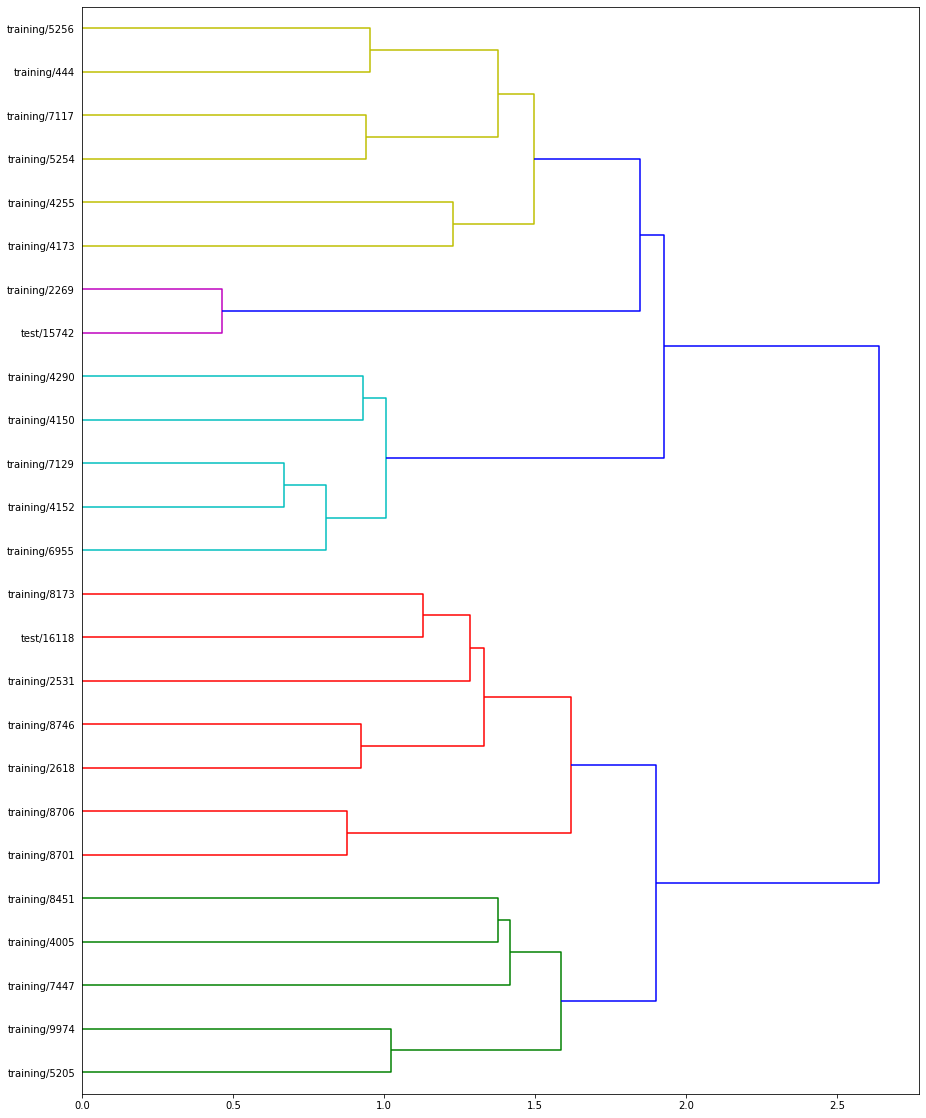

In [14]:
# hieararchial clusters with children 
linkage_matrix = linkage(dist, method = 'ward') # try different methods
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    
# plot dendogram
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels = df_retail.ids.unique())

In [15]:
# find the top flat clusters based on distance criteria 
f = fcluster(linkage_matrix, t = 1.9, criterion = 'distance')

# https://stackoverflow.com/questions/21638130/tutorial-for-scipy-cluster-hierarchy
# idea for scree plot to determine number of clusters in fcluster using 'maxclust' in criterion

In [16]:
# merge in with original data via pandas
frameh = pd.DataFrame(df_retail.index, index = [f], columns = ['index_retail'])
frameh = pd.merge(frameh, df_retail, right_index = True, left_on = 'index_retail')
frameh['cluster'] = frameh.index.str[0]
frameh = frameh.reset_index()

In [25]:
frameh

,level_0,index_retail,index,ids,categories,text,cluster
0,4,0,502,test/15742,[retail],us march retail sales cut by late easter us ...,4
1,2,1,717,test/16118,"[cpi, income, retail, trade, wpi]",yugoslav economy worsened in bank data shows ...,2
2,4,2,5811,training/2269,[retail],february us retail sales not sign of upturn ...,4
3,2,3,5974,training/2531,[retail],nz december quarter retail sales fall percent...,2
4,2,4,6038,training/2618,"[gnp, income, ipi, jobs, retail, trade]",february us jobs gains show stronger economy ...,2
5,1,5,6926,training/4005,"[interest, ipi, retail]",us economic data key to debt futures outlook ...,1
6,3,6,7035,training/4150,[retail],us retail sales rose percent in february nona...,3
7,3,7,7036,training/4152,[retail],us retail sales rise percent in february us...,3
8,4,8,7055,training/4173,[retail],uk retailers see growth in consumer spending ...,4
9,4,9,7107,training/4255,[retail],white house welcomes retail sales figures th...,4


In [19]:
# most common words in clusters 

labels = []
for i in list(frameh.cluster.unique()):
    # most common words
    cluster1 = list(frameh[frameh.cluster == i].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # max values in mean vector 
    lst = []

    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labels.append(lst)

__Find Documents at Each Level of Hierarchy__

In [31]:
# in linkage matrix, indicate the aggregated node for each node pair
links = pd.DataFrame(linkage_matrix)
links.columns = ['source1', 'source2', 'd', 'n']

links['target'] = 0
n = 24 
for i, row in links.iterrows():
    n += 1
    links.at[i,'target'] = n

In [21]:
# flatten irregular nested lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [22]:
def merge_docs(merge, source):
    merge = pd.merge(merge, merge[['target', 'docs']], left_on = source, right_on = 'target',  how = 'left')
    merge.docs_x = np.where(merge.docs_x.isnull(), '', merge.docs_x)
    merge.docs_y = np.where(merge.docs_y.isnull(), '', merge.docs_y)
    merge['docs'] = merge[['docs_x', 'docs_y']].values.tolist()
    merge = merge.drop(columns = ['docs_x', 'docs_y'])
    #merge.docs = merge.docs.apply(np.ravel)
    merge = merge.rename(columns = {'target_x':'target'})
    merge.docs = list(merge.docs.apply(lambda row: flatten(row)))
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])

    return merge

In [40]:
# initial merge between frame ids and source1/source2
merge = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
merge = pd.merge(merge, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
# create single docs list column 
merge = merge.rename(columns = {'ids_x':'docs1', 'ids_y':'docs2'})
merge.docs2 = np.where(merge.docs2.isnull(), '', merge.docs2)
merge.docs1 = np.where(merge.docs1.isnull(), '', merge.docs1)
merge['docs']= merge[['docs1', 'docs2']].values.tolist()
merge = merge.drop(columns = ['docs1', 'docs2'])
# flattern docs list column
merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
merge['len'] = merge.docs.apply(lambda row: len(set(row)))

merge1 = merge.copy()

# loop until have one id per document at node (n)
while int(merge[merge.target == merge.target.max()].len) != int(merge[merge.target == merge.target.max()].n): 
    merge = merge_docs(merge, 'source1')
    merge = merge_docs(merge, 'source2')
    merge['len'] = merge.docs.apply(lambda row: len(set(row)))
    
merge.docs = merge.docs.apply(lambda row: set(row))

In [35]:
# create graph reflecting hierarchy
G = nx.DiGraph()
G.add_nodes_from(links.source1)
G.add_nodes_from(links.source2)
G.add_nodes_from(links.target)

subset = links[['source1', 'target']]
G.add_edges_from([tuple(x) for x in subset.values])
subset = links[['source2', 'target']]
G.add_edges_from([tuple(x) for x in subset.values])

In [81]:
# add docs to each target node so know which docs exist at each target 
for i in list(merge.target.unique()):
    G.nodes[i]['docs'] = merge[merge.target == i].docs.values[0]
    
# add docs to origianl nodes as well 
ogdocs = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
ogdocs = pd.merge(ogdocs, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
for i in range(25):
    if len(ogdocs[ogdocs.source1 == i].ids_x) != 0:
        G.nodes[i]['docs'] = ogdocs[ogdocs.source1 == i].ids_x.values[0]
    if len(ogdocs[ogdocs.source2 == i].ids_y) != 0:
        G.nodes[i]['docs'] = ogdocs[ogdocs.source2 == i].ids_y.values[0]

In [84]:


# next: identify top level clusters and cutoff graph
# then figure out how to calculate within cluster metrics
     # are there centroids?? 

In [122]:
labels = []
for i in list(range(links.target.max())):
    # most common words
    if i < 25:
        cluster1 = list(frameh[frameh.ids == list(G.nodes[i].values())[0]].index.unique())
    else:
        cluster1 = list(frameh[frameh.ids.isin(list(list(G.nodes[i].values())[0]))].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # max values in mean vector 
    lst = []

    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labels.append(lst)

In [123]:
labels

[['sales', 'million', 'apparel'],
 ['currency', 'percent', 'bank'],
 ['sales', 'million', 'strong'],
 ['quarter', 'december', 'recorded'],
 ['employment', 'hours', 'said'],
 ['futures', 'june', 'range'],
 ['sales', 'rose', 'nonauto'],
 ['percent', 'sales', 'january'],
 ['survey', 'march', 'retailers'],
 ['figures', 'white', 'house'],
 ['sales', 'percent', 'february'],
 ['february', 'prices', 'turkish'],
 ['office', 'turnover', 'german'],
 ['janurary', 'provisional', 'uk'],
 ['february', 'final', 'sales'],
 ['nz', 'january', 'sales'],
 ['decembers', 'canada', 'official'],
 ['sales', 'percent', 'canada'],
 ['appliance', 'shipments', 'million'],
 ['percent', 'year', 'years'],
 ['consumption', 'purchases', 'insee'],
 ['nondefense', 'durables', 'rose'],
 ['orders', 'percent', 'january'],
 ['economic', 'quarter', 'economy'],
 ['german', 'turnover', 'retailers'],
 ['sales', 'million', 'analysts'],
 ['sales', 'percent', 'january'],
 ['sales', 'percent', 'january'],
 ['orders', 'percent', 'rose

In [ ]:
# kmeans 
# need to research and mess with paramters 
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(m)

clusters = km.labels_.tolist()

In [ ]:
# merge in with original data via pandas
frame = pd.DataFrame(df_retail.index, index = [clusters], columns = ['index_retail'])
frame = pd.merge(frame, df_retail, right_index = True, left_on = 'index_retail')
frame['cluster'] = frame.index.str[0]
frame = frame.reset_index()

In [ ]:
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
order_centroids

In [ ]:
frame.cluster.value_counts() # number of documents per cluster 

## http://brandonrose.org/clustering : more info on finding most common words in cluster, visualizing, hierarchial 
# also try taking average of tf-idf per cluster and using that way. 

In [ ]:
# most common words in clusters 

labels = []
for i in range(3):
    # most common words
    cluster1 = list(frame[frame.cluster == i].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # max values in mean vector 
    lst = []

    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labels.append(lst)

In [ ]:
# visualization based on distances: x and y coordinates  

###### should use tsne or umap in reality 

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = clusters))

In [ ]:
cluster_labels = dict()
for i in range(len(labels)):
    cluster_labels[i] = labels[i]
    
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

In [ ]:
fig, ax = plt.subplots(figsize=(17, 9)) 

groups = df_vis.groupby('cluster')

for name, group in groups:
    ax.scatter(group.x, group.y, c  = cluster_colors[name], label = cluster_labels[name])
    ax.legend()

In [ ]:
#svd
# try following lingo algorithm as per paper
u,s,v = np.linalg.svd(m.todense().T, full_matrices = False) # full_matrices make dimensions work. Min(M,N) (why necessary??)
s = np.diag(s)

In [ ]:
m.shape

In [ ]:
cluster1

In [ ]:
x = np.matmul(s,v.T)
np.matmul(u, x)

In [ ]:
# get unique list of topics (categories)
topics = list(df.categories)
topics = [item for sublist in topics for item in sublist]
topics = set(topics)


df[df.categories.map(set(['earn']).issubset)]

df['len'] = df.text.apply(lambda row: len(row))
